## Area and accuracy estimations - Olofsson

Calculate Area, Accuracy stats as described in the paper: 
Olofsson et al., 2014 https://doi.org/10.1016/j.rse.2014.02.015

-> The inputs for the code would be the Confusion Matrix and the Total pixels by Map class in the same order as of the matrix.
Everything else will be computed from the provided variables. 

-> Additionally, input the labels for visualization.

-> There are cells which are redundant, which exist just to cross verify calculations. These are marked by '''REDUNDANT''' in the beginning. These can be safely deleted.

In [71]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report


In [72]:
cm = np.array([
    [309 , 1 , 5 , 0, 3],
    [7, 49 , 10 ,1 , 14],
    [6,  2 , 105, 1, 0 ],
    [5 , 2 , 2 , 141 , 2],
    [18 , 17, 11, 0, 189]
])
confusionMatrix = cm.T # Resembling Olofsson Paper

list_of_N = [26029895.04 ,  968635.66 ,  6296973.80 ,  1339561.92,  14663367.14 ]
labels = ['Non-crop','Barren Fallow','Winter-cereal', 'Rapeseed','Spring-crop']



## Visualize Confusion Matrix (Nij)

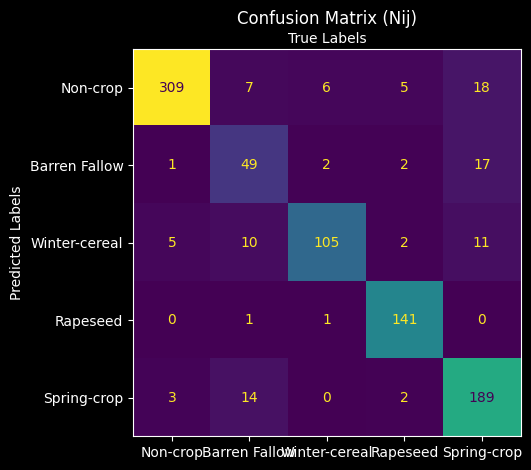

In [73]:
plt.style.use('dark_background')
fig, ax = plt.subplots()

disp = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix , display_labels = labels)
disp.plot(ax=ax,colorbar=False)
# Swap axis labels
ax.set_xlabel('True Labels')
ax.set_ylabel('Predicted Labels')
ax.xaxis.set_label_position('top')
#ax.xaxis.tick_top()
plt.title('Confusion Matrix (Nij)')
plt.tight_layout()


# Area , Accuracy Stats

In [74]:
'''
Define variables to be used in the loops
'''

#Final variable holding all metrics
allMetrics = {} 

numberOfClasses = len(confusionMatrix[0])
assert len(confusionMatrix[0]) == len(confusionMatrix[1]) ,"Confusion Matrix has to be a square."

total_pixels = sum(list_of_N)
#Weights of each strata. In Stratified sampling, W would be different for every strata.
#When strata = Map Class, weight is the proportionality of the Map Class.
W = [list_of_N[i]/total_pixels for i in range(numberOfClasses)]

#Allow for a tiny error margin.
assert sum(W) <1.001 and sum(W)>0.999 ,"Pixel counted area proportions aren't summing upto 1."    



## Areas

In [75]:
Areas = [  sum(Pij[:,i]) * total_pixels for i in range(numberOfClasses)]
allMetrics['Areas'] = Areas

## Overall Accuracy

In [76]:

allMetrics['Overall Accuracy'] = 0
for i in range(numberOfClasses):
    tp = confusionMatrix[i,i]
    total_predicted  = sum(confusionMatrix[i,:])
    predicted_pixels = list_of_N[i]
    W1  = predicted_pixels / total_pixels
    tp_proportional = (tp / (total_predicted)) * W1
    allMetrics ['Overall Accuracy'] += tp_proportional
    


In [77]:
'''REDUNDANT'''

#Pij will be calculated later. This is redundant, just for ease of access.
P_i_i = [W[i] *confusionMatrix[i,i]/sum(confusionMatrix[i]) for i in range(numberOfClasses)]
#Calulating 2 ways and asserting just to be sure.
OA = sum(P_i_i)

assert OA == allMetrics['Overall Accuracy'] , f"OA calculated 2 ways - {OA} , {allMetrics['Overall Accuracy']} don't match. If its just a decimal precision issue, you can remove this assert."



## Pij

In [78]:
Pij = np.zeros((numberOfClasses,numberOfClasses))
# Proportional confusion matrix. 
ni = [sum(confusionMatrix[i]) for i in range(numberOfClasses)]
for i in range(numberOfClasses):
    for j in range(numberOfClasses):
        Pij[i,j] = W[i] *  confusionMatrix[i,j] / ni[i]
        

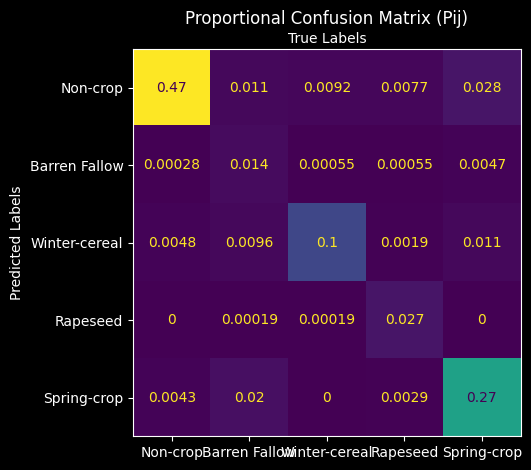

In [79]:
plt.style.use('dark_background')
fig, ax = plt.subplots()

disp = ConfusionMatrixDisplay(confusion_matrix = Pij , display_labels = labels)
disp.plot(ax=ax,colorbar=False)
# Swap axis labels
ax.set_xlabel('True Labels')
ax.set_ylabel('Predicted Labels')
ax.xaxis.set_label_position('top')
#ax.xaxis.tick_top()
plt.title('Proportional Confusion Matrix (Pij)')
plt.tight_layout()

## User's , Producer's

In [80]:
allMetrics['Ui'] = U_i = [Pij[i,i]/sum(Pij[i,j] for j in range(numberOfClasses)) for i in range(numberOfClasses)]
allMetrics['Prodi'] =Prod_i = [ Pij[i,i]/sum(Pij[j,i] for j in range(numberOfClasses)) for i in range(numberOfClasses)]


In [81]:
'''REDUNDANT'''

'''
Marginal totals (Pi. and P.i).
'''
P_i_dot =[]
#The denominator term in Ui. Proportional total_predicted of class i.
for i in range(numberOfClasses):
    P_i_dot.append(sum(W[i] * confusionMatrix[i,j]/sum(confusionMatrix[i])  for j in range(numberOfClasses)))
    
P_dot_i = []
    #Denominator terms in Producers. Estimated Proportional total_true of class i
for i in range(numberOfClasses):
    P_dot_i.append(sum(W[j]*confusionMatrix[j,i]/sum(confusionMatrix[j]) for j in range(numberOfClasses)))

U_i_backup = [ P_i_i[i]/P_i_dot[i] for i in range(numberOfClasses)]
Prod_i_backup = [P_i_i[i]/P_dot_i[i] for i in range(numberOfClasses)]
assert U_i_backup == allMetrics['Ui'] 
assert allMetrics['Prodi'] == Prod_i_backup

## Variances

In [82]:

"VARIANCES"
"1. User's Variance"

VU_i = [ U_i[i] * (1-U_i[i])/sum(confusionMatrix[i]) for i in range(numberOfClasses)]
allMetrics['User\'s Variance'] = VU_i
allMetrics['User\'s Standard Error'] = np.sqrt(VU_i)
allMetrics['User\'s 95% Error'] = 1.96*np.sqrt(VU_i)

"2. Producer's Variance"
VP_j = []
N_i_dot = list_of_N.copy() #?
N_dot_i = []
for j in range(numberOfClasses):
    N_dot_i.append(sum( N_i_dot[i] * confusionMatrix[i,j] / sum(confusionMatrix[i]) for i in range(numberOfClasses)))

exp1 = []
for j in range(numberOfClasses):
    exp = (N_i_dot[j] **2 * (1 - Prod_i[j])**2 * U_i[j] * (1- U_i[j])) / (sum(confusionMatrix[j]) -1)
    exp1.append(exp)
exp2 = []
for j in range(numberOfClasses):
    exp = Prod_i[j] **2 
    subexp = []
    for i in range(numberOfClasses):
        if(i==j):
            continue
        subexp.append( (list_of_N[i]**2 * confusionMatrix[i,j] / sum(confusionMatrix[i])) * 
                        
                     (1 - (confusionMatrix[i,j]/sum(confusionMatrix[i]))) / (sum(confusionMatrix[i]) - 1)
                     )
    exp = exp * sum(subexp)
    exp2.append(exp)
allMetrics['Prod exp N_dot_i']= N_dot_i
allMetrics['Prod exp 1'] = exp1
allMetrics['Prod exp 2'] = exp2
VP_j = [(1/(N_dot_i[j]**2) )*(exp1[j] +exp2[j] ) for j in range(numberOfClasses)]
allMetrics['Producer\'s Variance'] = VP_j
allMetrics['Produser\'s Standard Error'] = np.sqrt(VP_j)
allMetrics['Produser\'s 95% Error'] = 1.96*np.sqrt(VP_j)

"3. Overall"
VOA = sum(W[i]**2 * VU_i[i] for i in range(numberOfClasses))
allMetrics['Overall accuracy Variance'] = VOA
allMetrics['Accuracy std error'] = np.sqrt(VOA)
allMetrics['Accuracy 95% Error'] = 1.96*np.sqrt(VOA)

"4. Areas"
AreasSTDERR = []
for k in range(numberOfClasses):
    AreasSTDERR.append(np.sqrt(sum( ((W[i]*Pij[i,k])-(Pij[i,k]**2))/(sum(confusionMatrix[i])-1) \
                              for i in range(numberOfClasses)   )))        
allMetrics['Area Standard Error'] = AreasSTDERR
Areasstdtot = [total_pixels*AreasSTDERR[i] for i in range(numberOfClasses)]
allMetrics['Areas STD error to total Area'] = Areasstdtot

In [83]:
allMetrics

{'Areas': [23775594.045636397,
  2666419.4770904914,
  5460642.009469187,
  1961042.405599256,
  15434735.622204663],
 'Overall Accuracy': 0.8843744274763102,
 'Ui': [0.8956521739130436,
  0.6901408450704226,
  0.7894736842105263,
  0.986013986013986,
  0.908653846153846],
 'Prodi': [0.9805741145543819,
  0.25070887709205686,
  0.9103865619907945,
  0.6735330069765265,
  0.8632428358642505],
 "User's Variance": [0.00027089668776197873,
  0.0030119219582521906,
  0.0012496615499968757,
  9.643640139018866e-05,
  0.00039904824049840737],
 "User's Standard Error": array([0.01645894, 0.05488098, 0.03535055, 0.0098202 , 0.01997619]),
 "User's 95% Error": array([0.03225952, 0.10756672, 0.06928708, 0.0192476 , 0.03915334]),
 'Prod exp N_dot_i': [23775594.045636397,
  2666419.4770904914,
  5460642.009469188,
  1961042.4055992563,
  15434735.622204665],
 'Prod exp 1': [69465765.84017414,
  1609259586.8281105,
  400940722.38740975,
  18573460.80953368,
  1612448972.112989],
 'Prod exp 2': [24826